Kanyao Han        
MACSS 30100

# Problem Set  #5

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from pylab import rcParams
import statsmodels.api as sm
from sklearn.model_selection import LeaveOneOut, KFold

import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings("ignore") 
%matplotlib inline

F:\python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
F:\python\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Part one
### a)

In [2]:
drink = pd.read_csv('strongdrink.txt')

In [3]:
X = drink[['alco', 'malic', 'tot_phen', 'color_int']]
y = drink[['cultivar']]
# This function train_test_split is from sklearn.cross_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25,
                                                    random_state=20)
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')

result = MultLogReg.fit(X_train, y_train)

In [4]:
print('When j = 1:')
print(' b0 =', result.intercept_[0], '   b1 =', result.coef_[0][0],
      '\n b2 =', result.coef_[0][1], ' b3 =', result.coef_[0][2],
      '  b4 =', result.coef_[0][3])
print('\nWhen j = 2:')
print(' b0 =', result.intercept_[1], '   b1 =', result.coef_[1][0],
      '\n b2 =', result.coef_[1][1], '  b3 =', result.coef_[1][2],
      '  b4 =', result.coef_[1][3])

When j = 1:
 b0 = -24.01128475672811    b1 = 1.7004277027443333 
 b2 = -0.26560800335967705  b3 = 1.2238949474823475   b4 = 0.02275091895283019

When j = 2:
 b0 = 22.80205963506117    b1 = -1.4680142949590438 
 b2 = -0.3330517398967017   b3 = 0.6640071553102961   b4 = -0.9227102959603717


In [5]:
y_pred = MultLogReg.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[13  0  0]
 [ 2 19  0]
 [ 0  0 10]]


In [6]:
print(classification_report(y_test, y_pred, digits=3))
y_test = np.array([y_test['cultivar']])
print('The error rate (class 1) is', 1 - 0.867,
      '\nThe error rate (class 2) is', 1 - 1,
      '\nThe error rate (class 3) is', 1 - 1)
print('The test MSE is', (y_test != y_pred).astype(int).mean())

             precision    recall  f1-score   support

          1      0.867     1.000     0.929        13
          2      1.000     0.905     0.950        21
          3      1.000     1.000     1.000        10

avg / total      0.961     0.955     0.955        44

The error rate (class 1) is 0.133 
The error rate (class 2) is 0 
The error rate (class 3) is 0
The test MSE is 0.045454545454545456


In [7]:
drink.cultivar.value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

On the surface, the predictive results in both class 2 (with most obs) and class 3 (with least obs) are very similar and class 3 can be slightly better than class 2 at predicting because it has a smaller recall score. Therefore, at least in this case, the most accurately predicted category is not necessarily the one with the most observations.

However, the results here are not robust. When we try different random states, we can find that the results are not always robust. In this case, it is not sutible to make a conclusion since the test set is small.

In [8]:
Xvars = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = drink['cultivar'].values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE = pd.DataFrame({'index': np.zeros(N_loo), 
                    'error': np.zeros(N_loo), 
                    'y_pred': np.zeros(N_loo),
                    'y_test': np.zeros(N_loo)})

# This loop will take 20 or 30 seconds
for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE['index'][test_index] = test_index
    MSE['error'][test_index] = (y_test != y_pred).astype(int)
    MSE['y_pred'][test_index] = y_pred
    MSE['y_test'][test_index] = y_test

error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()
General_MSE = MSE['error'].mean()

print(classification_report(MSE['y_test'], MSE['y_pred'], digits=3))
print('Although I provide the classifaction report, but it does not tell us the std and MSE.\
 Therefore, I compute the error rates, std and average MSE directly')
print('')
print('The error rate for class 1 is', error_1, ', std is', MSE[MSE['y_pred'] == 1]['error'].std())
print('The error rate for class 2 is', error_2, ', std is', MSE[MSE['y_pred'] == 2]['error'].std())
print('The error rate for class 3 is', error_3, ', std is', MSE[MSE['y_pred'] == 3]['error'].std())
print('The average MSE (for all classes) is', General_MSE,
      ', std is', MSE['error'].std())

             precision    recall  f1-score   support

        1.0      0.902     0.932     0.917        59
        2.0      0.914     0.901     0.908        71
        3.0      0.956     0.935     0.945        46

avg / total      0.921     0.920     0.921       176

Although I provide the classifaction report, but it does not tell us the std and MSE. Therefore, I compute the error rates, std and average MSE directly

The error rate for class 1 is 0.09836065573770492 , std is 0.3002730997379377
The error rate for class 2 is 0.08571428571428572 , std is 0.2819629507400967
The error rate for class 3 is 0.044444444444444446 , std is 0.20840907713999288
The average MSE (for all classes) is 0.07954545454545454 , std is 0.2713602101199873


Compared to part(a), the error rate for class 1 become slightly smaller but those for class 2 and class 3 become much larger. The average MSE is also bigger than that in part(a). Besides, the error rate of class 3 here is smaller than those for class 2 and class 1: the class with least observations has the lowest error rate! Finally, it is also worth noting that the standard deviation of results in LOOCV are relatively large.

In [9]:
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)
General_error_1 = np.zeros(k)
General_error_2 = np.zeros(k)
General_error_3 = np.zeros(k)
General_MSE = np.zeros(k)

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    print('When k index=', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE = pd.DataFrame({'error': (y_test != y_pred).astype(int), 
                        'y_pred': y_pred})
    error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
    error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
    error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()
    error_all_class = MSE['error'].mean()
    General_error_1[k_ind] = error_1
    General_error_2[k_ind] = error_2
    General_error_3[k_ind] = error_3
    General_MSE[k_ind] = error_all_class
    print('\n',classification_report(y_test, y_pred, digits=3))
    print('error rate (class 1) is', error_1,
          ', error rate (class 2) is', error_2,
          ', error rate (class 3) is', error_3)
    print('MSE (for all classes) is', error_all_class)
    print('The stds are respectively', MSE[MSE['y_pred'] == 1]['error'].std(),
          ',', MSE[MSE['y_pred'] == 2]['error'].std(),
          ',', MSE[MSE['y_pred'] == 3]['error'].std(),
          ',', MSE['error'].std(),'\n')    
    k_ind += 1


print('\nk-fold resuts:')
print('The average error rate (class 1) is', General_error_1.mean(), ', std is', General_error_1.std())
print('The average error rate (class 2) is', General_error_2.mean(), ', std is', General_error_2.std())
print('The average error rate (class 3) is', General_error_3.mean(), ', std is', General_error_3.std())
print('The average MSE (for all classes) is', General_MSE.mean(), ', std is', General_MSE.std())

When k index= 0

              precision    recall  f1-score   support

          1      0.706     1.000     0.828        12
          2      1.000     0.750     0.857        24
          3      0.778     0.875     0.824         8

avg / total      0.879     0.841     0.843        44

error rate (class 1) is 0.29411764705882354 , error rate (class 2) is 0.0 , error rate (class 3) is 0.2222222222222222
MSE (for all classes) is 0.1590909090909091
The stds are respectively 0.46966821831386213 , 0.0 , 0.44095855184409843 , 0.36998942902446835 

When k index= 1

              precision    recall  f1-score   support

          1      1.000     0.765     0.867        17
          2      0.688     1.000     0.815        11
          3      1.000     0.938     0.968        16

avg / total      0.922     0.886     0.890        44

error rate (class 1) is 0.0 , error rate (class 2) is 0.3125 , error rate (class 3) is 0.0
MSE (for all classes) is 0.11363636363636363
The stds are respectively 0.0 ,

The error rates in K-fold are generally similar to those in LOOCV (slightly larger in K-fold). In other words, the error rates in K-fold and LOOCV in class 1 are smaller than that in part(a) and those in other two categories are larger. The average MSEs in them are also larger than that in class 1.    

Besides, the error rates of class 3 in both LOOCV and K-folder are smaller than those for class 2 and class 1. It comfirms the conclusion that the category with largest number of observations not necessarily has the best predictive result.

Finally, K-fold and LOOCV methods have similar results but the former can provide smaller standard deviations. Therefore, it seems that K-fold is better than LOOCV in this data set.  

## Part two
### a)

In [10]:
cool = pd.read_csv('CoolIndex.txt', header = None)
cool.columns = ['age', 'Coolness']

Text(0,0.5,'Coolness Index')

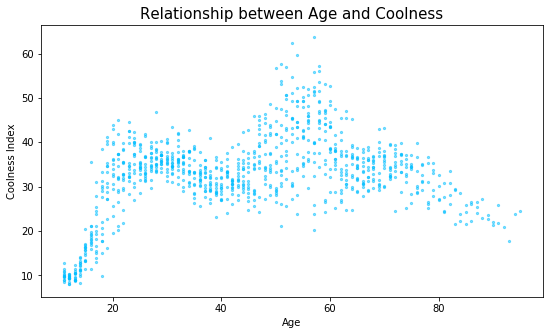

In [11]:
age = cool['age']
coolness = cool['Coolness']
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)
fig = plt.figure(figsize = (9,5))
plt.scatter(age, coolness, s = 5, c = 'deepskyblue', alpha = 0.5)
plt.title('Relationship between Age and Coolness', fontsize = 15)
plt.xlabel('Age')
plt.ylabel("Coolness Index")

### b)

In [12]:
age_11_22 = ((age >= 11) & (age < 22)).astype(int)
age_22_40 = ((age >= 22) & (age < 40)).astype(int)
age_40_59 = ((age >= 40) & (age < 59)).astype(int)
age_59_77 = ((age >= 59) & (age < 77)).astype(int)
age_77_95 = ((age >= 77) & (age <= 95)).astype(int)
X_step = pd.DataFrame(dict(age_11_22=age_11_22, age_22_40=age_22_40,
                           age_40_59=age_40_59, age_59_77=age_59_77,
                           age_77_95=age_77_95))
X_step.describe()

,age_11_22,age_22_40,age_40_59,age_59_77,age_77_95
count,956.000000,956.000000,956.000000,956.000000,956.000000
mean,0.162134,0.276151,0.285565,0.217573,0.058577
std,0.368767,0.447326,0.451919,0.412812,0.234955
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
reg2 = sm.OLS(endog=coolness, exog=X_step, missing='drop')
reg2_results = reg2.fit()

Text(0,0.5,'Coolness Index')

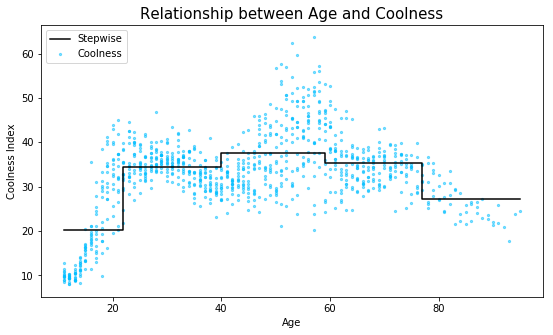

In [14]:
age_step = np.array([11, 22, 40, 59, 77, 95])
cool_step = np.append(reg2_results.params[0], reg2_results.params)
fig = plt.figure(figsize = (9,5))
plt.scatter(age, coolness, s = 5, c = 'deepskyblue', alpha = 0.5)
plt.step(age_step, cool_step, 'k-', label='Stepwise')
plt.legend(loc='upper left')
plt.title('Relationship between Age and Coolness', fontsize = 15)
plt.xlabel('Age')
plt.ylabel("Coolness Index")

In [15]:
print(reg2_results.summary())

                            OLS Regression Results                            
Dep. Variable:               Coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sun, 18 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        21:07:57   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_11_22     20.1025      0.562     35.746      0.0

In [16]:
b1, b2, b3, b4, b5 = reg2_results.params
print('b1 =', b1, ', b2 =', b2,
      ', b3 =', b3, ', b4 =', b4,
      ', b5 =', b5)

b1 = 20.102457252090748 , b2 = 34.475788077559386 , b3 = 37.63510549244961 , b4 = 35.225400040242754 , b5 = 27.296378244321282


In [17]:
print('Predicted Coolness of 73-year old is', reg2_results.params[3])

Predicted Coolness of 73-year old is 35.225400040242754


### c)

In [18]:
from scipy.interpolate import LSQUnivariateSpline

Text(0,0.5,'Coolness Index')

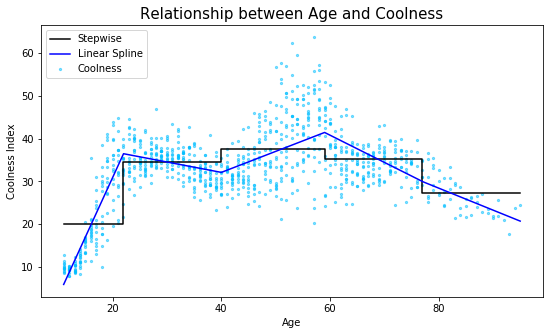

In [19]:
knots = [22, 40, 59, 77]
spl_cool1 = LSQUnivariateSpline(age.values, coolness.values, knots, k=1)
fig = plt.figure(figsize = (9,5))
plt.scatter(age, coolness, s = 5, c = 'deepskyblue', alpha = 0.5)
plt.step(age_step, cool_step, 'k-', label='Stepwise')
plt.plot(age_vec, spl_cool1(age_vec), 'b-', label='Linear Spline')
plt.legend(loc='upper left')
plt.title('Relationship between Age and Coolness', fontsize = 15)
plt.xlabel('Age')
plt.ylabel("Coolness Index")

In [20]:
predicted_age2 = spl_cool1(73)
print('Predicted Coolness of 73-year old is', predicted_age2)

Predicted Coolness of 73-year old is 32.536832389143306


### d)

Text(0,0.5,'Coolness Index')

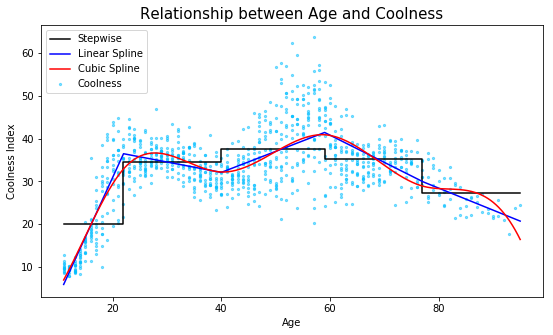

In [21]:
spl_cool2 = LSQUnivariateSpline(age.values, coolness.values, knots, k=3)
fig = plt.figure(figsize = (9,5))
plt.scatter(age, coolness, s = 5, c = 'deepskyblue', alpha = 0.5)
plt.step(age_step, cool_step, 'k-', label = 'Stepwise')
plt.plot(age_vec, spl_cool1(age_vec), 'blue', label = 'Linear Spline')
plt.plot(age_vec, spl_cool2(age_vec), 'red', label = 'Cubic Spline')
plt.legend(loc='upper left')
plt.title('Relationship between Age and Coolness', fontsize = 15)
plt.xlabel('Age')
plt.ylabel("Coolness Index")

In [22]:
predicted_age3 = spl_cool2(73)
print('Predicted Coolness of 73-year old =', predicted_age3)

Predicted Coolness of 73-year old = 31.262429389257864
